Starting training... (May the cosmic forces be with you!)
Epoch 1/5, Loss: 2.7258
Epoch 2/5, Loss: 2.7202
Epoch 3/5, Loss: 2.7194
Epoch 4/5, Loss: 2.7191
Epoch 5/5, Loss: 2.7194
Training complete! Now your model is ready to learn the cosmic secrets.


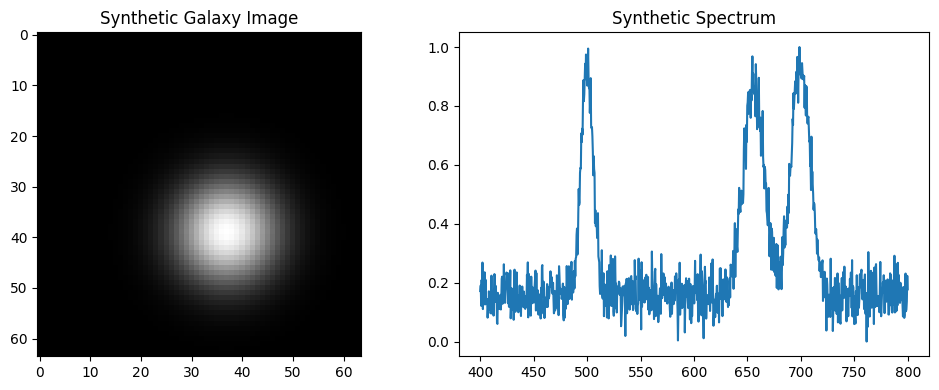

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# -------------------------------
# Synthetic Data Generation
# -------------------------------

def generate_synthetic_galaxy_image():
    """
    Generates a synthetic 64x64 grayscale image with a single Gaussian blob,
    mimicking a galaxy.
    """
    image = np.zeros((64, 64), dtype=np.float32)
    # Randomly choose the galaxy's center, ensuring it's not too close to the edges.
    x_center = np.random.randint(20, 44)
    y_center = np.random.randint(20, 44)
    xv, yv = np.meshgrid(np.arange(64), np.arange(64))
    sigma = np.random.uniform(3, 8)
    blob = np.exp(-((xv - x_center)**2 + (yv - y_center)**2) / (2 * sigma**2))
    image += blob
    # Normalize to [0, 1]
    image = image / image.max()
    return image

def generate_synthetic_spectrum():
    """
    Generates a synthetic 1D spectrum over wavelengths 400-800 nm with a few Gaussian peaks
    (e.g., H-alpha near 656 nm) plus noise.
    """
    wavelengths = np.linspace(400, 800, 1000)  # in nm
    spectrum = np.zeros_like(wavelengths)
    # Add some peaks to mimic spectral lines (you can add more realism here!)
    peaks = [500, 656, 700]
    for peak in peaks:
        amplitude = np.random.uniform(0.5, 1.0)
        sigma = np.random.uniform(5, 15)
        spectrum += amplitude * np.exp(-0.5 * ((wavelengths - peak) / sigma)**2)
    # Add Gaussian noise (because even galaxies have a bit of chaos)
    noise = np.random.normal(0, 0.05, size=wavelengths.shape)
    spectrum += noise
    # Normalize spectrum between 0 and 1
    spectrum = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())
    return wavelengths, spectrum

# -------------------------------
# Dataset Class
# -------------------------------

class GalaxyDataset(Dataset):
    def __init__(self, num_samples=200):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = generate_synthetic_galaxy_image()  # (64,64)
        _, spectrum = generate_synthetic_spectrum()  # (1000,)
        # Add a channel dimension to the image: (1, 64, 64)
        image = np.expand_dims(image, axis=0)
        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        spectrum = torch.tensor(spectrum, dtype=torch.float32)
        return image, spectrum

# -------------------------------
# Model Definitions
# -------------------------------

class ImageEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ImageEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, embedding_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)

class SpectrumEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SpectrumEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)

# -------------------------------
# Dummy Diffusion Process
# -------------------------------

def apply_diffusion(x, t):
    """
    A dummy diffusion function that adds Gaussian noise to simulate a diffusion step.
    The noise level is proportional to the time step 't'.
    """
    noise = torch.randn_like(x) * (t / 10.0)
    return x + noise

# -------------------------------
# Contrastive Loss Function
# -------------------------------

def contrastive_loss(image_embeddings, spectrum_embeddings, temperature=0.1):
    """
    Computes a simple contrastive (InfoNCE) loss that aligns image and spectrum embeddings.
    """
    batch_size = image_embeddings.shape[0]
    # Normalize embeddings
    image_norm = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)
    spectrum_norm = spectrum_embeddings / spectrum_embeddings.norm(dim=1, keepdim=True)
    # Compute cosine similarity matrix
    logits = torch.mm(image_norm, spectrum_norm.t()) / temperature
    labels = torch.arange(batch_size).to(logits.device)
    loss_i = nn.CrossEntropyLoss()(logits, labels)
    loss_s = nn.CrossEntropyLoss()(logits.t(), labels)
    loss = (loss_i + loss_s) / 2
    return loss

# -------------------------------
# Training Setup
# -------------------------------

# Hyperparameters
embedding_dim = 128
batch_size = 16
num_epochs = 5
learning_rate = 1e-3

# Create dataset and dataloader
dataset = GalaxyDataset(num_samples=200)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_encoder = ImageEncoder(embedding_dim=embedding_dim).to(device)
spectrum_encoder = SpectrumEncoder(embedding_dim=embedding_dim).to(device)

optimizer = optim.Adam(list(image_encoder.parameters()) + list(spectrum_encoder.parameters()), lr=learning_rate)

# -------------------------------
# Training Loop
# -------------------------------

print("Starting training... (May the cosmic forces be with you!)")
for epoch in range(num_epochs):
    total_loss = 0
    for image, spectrum in dataloader:
        image = image.to(device)
        spectrum = spectrum.to(device)
        # Apply dummy diffusion noise to simulate degradation (because galaxies sometimes like a bit of drama)
        t = random.uniform(0, 1)
        image_noisy = apply_diffusion(image, t)
        spectrum_noisy = apply_diffusion(spectrum, t)
        
        # Obtain embeddings
        img_emb = image_encoder(image_noisy)
        spec_emb = spectrum_encoder(spectrum_noisy)
        
        # Compute contrastive loss to align the modalities
        loss = contrastive_loss(img_emb, spec_emb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete! Now your model is ready to learn the cosmic secrets.")

# -------------------------------
# Visualization
# -------------------------------

# Visualize one example to ensure data generation is working (and to admire our little simulated galaxy)
image, spectrum = dataset[0]
wavelengths = np.linspace(400, 800, 1000)  # using same wavelength grid as in the generator

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Synthetic Galaxy Image")
ax[1].plot(wavelengths, spectrum.numpy())
ax[1].set_title("Synthetic Spectrum")
plt.tight_layout()
plt.show()